In [1]:
import pandas as pd
import os
from datetime import datetime
import seaborn as sns 
import numpy as np

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Bidirectional, Flatten

#data_dir = "path/to/csv_folder"
data_dir="./unzipped_data"
csv_files = sorted(
    [f for f in os.listdir(data_dir) if f.endswith(".csv")],
    key=lambda x: datetime.strptime(x.split(".")[0], "%Y%m%d")
)

2025-05-02 18:04:03.784957: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 18:04:03.797822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746180243.810960    2144 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746180243.814783    2144 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746180243.825543    2144 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
import pandas as pd
import os
import glob


In [3]:
from statsmodels.tsa.stattools import adfuller

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:

# 自定义时间戳解析函数（包含秒）
def parse_custom_datetime(date_str):
    try:
        # 尝试解析完整格式（含秒）
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        # 处理缺失秒的情况（如 "2017-01-03 09:00"）
        return datetime.strptime(date_str, "%Y-%m-%d %H:%M")



merged_df = pd.concat(
    [pd.read_csv(
        os.path.join(data_dir, f),
        parse_dates=["datetime"],  # 直接解析单列
        date_parser=parse_custom_datetime
    ) for f in csv_files],
    ignore_index=True
)

# 处理主力合约切换（按时间和合约降序排序）
merged_df = merged_df.sort_values(["datetime", "contract"], ascending=[True, False])
merged_df = merged_df.drop_duplicates(subset=["datetime", "symbol"], keep="first")

# 检查结果
print(merged_df.head())

                datetime contract symbol exchange    open    high     low  \
1125 2017-01-03 09:00:00   SM1705     SM     CZCE  6900.0  6900.0  6846.0   
900  2017-01-03 09:00:00   SF1706     SF     CZCE  5122.0  5122.0  5122.0   
675  2017-01-03 09:00:00   RB1705     RB     SHFE  2889.0  2898.0  2881.0   
450  2017-01-03 09:00:00   JM1705     JM      DCE  1180.0  1180.0  1158.0   
225  2017-01-03 09:00:00    I1705      I      DCE   551.0   553.0   549.0   

       close  openinterest  volume     amount  
1125  6872.0          9896     102          0  
900   5122.0             4       0          0  
675   2888.0       1216826   31140  899980280  
450   1172.5         78285    1309   91655250  
225    551.0        459447    6531  359950150  


In [6]:
# 检查重复项
duplicates = merged_df.duplicated(subset=["datetime", "symbol"], keep=False)
print(f"重复记录数量：{duplicates.sum()}")
# 期望输出：重复记录数量：0

重复记录数量：0


In [7]:
trading_hours = pd.date_range("09:00", "15:00", freq="1T").time
full_range = pd.date_range(start=merged_df["datetime"].min(), end=merged_df["datetime"].max(), freq="1T")
#full_range = full_range[full_range.time.isin(trading_hours)]
#full_range = full_range[full_range.time.inld(trading_hours)]

In [8]:
print(np.__version__)


1.26.4


In [9]:
missing_times = full_range.difference(merged_df["datetime"])
print(f"交易时段内缺失时间点数量：{len(missing_times)}")

交易时段内缺失时间点数量：3513135


In [10]:
merged_df = (
    merged_df.set_index("datetime")                    # 设置 "datetime" 为索引
    .groupby("symbol")                                 # 按 "symbol" 分组
    .resample("1T")                                    # 按1分钟重采样
    .ffill()                                           # 前向填充
    .reset_index(level="symbol", drop=True)            # 仅重置 "symbol" 层索引并丢弃，避免重复列
    .reset_index()                                     # 重置剩余索引为列
)

In [11]:
merged_df.columns

Index(['datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low',
       'close', 'openinterest', 'volume', 'amount'],
      dtype='object')

In [12]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,amount
0,2017-01-03 09:00:00,HC1705,HC,SHFE,3309.0,3324.0,3309.0,3317.0,176894,2259,74917650
1,2017-01-03 09:01:00,HC1705,HC,SHFE,3317.0,3326.0,3317.0,3323.0,176669,963,31985320
2,2017-01-03 09:02:00,HC1705,HC,SHFE,3323.0,3399.0,3323.0,3381.0,176084,4921,166005070
3,2017-01-03 09:03:00,HC1705,HC,SHFE,3383.0,3384.0,3370.0,3377.0,175392,2095,70779590
4,2017-01-03 09:04:00,HC1705,HC,SHFE,3377.0,3396.0,3377.0,3392.0,174824,2793,94695420


In [13]:
output_dir="./output"

In [14]:
merged_df.to_csv(
    os.path.join(output_dir, "merged_futures_data.csv"),  # 路径：processed_data/merged_futures_data.csv
    index=False,  # 不保存索引
    encoding="utf-8-sig"  # 支持中文编码
)

 # 1. 处理重复数据
>确保每个时间戳（datetime）和品种（symbol）组合唯一，保留最新合约数据。

In [15]:
# 按时间和合约降序排序，确保最新合约在前
merged_df = merged_df.sort_values(["datetime", "contract"], ascending=[True, False])

# 去重，保留每个时间戳和品种的第一条记录（即最新合约）
merged_df = merged_df.drop_duplicates(subset=["datetime", "symbol"], keep="first")

# 验证结果
print("重复记录数量:", merged_df.duplicated(subset=["datetime", "symbol"]).sum())

重复记录数量: 0


# 2. 处理零成交量和持仓量
>
>删除无效数据（如零成交量或负持仓量）

In [16]:
# 删除成交量为零的记录
merged_df = merged_df[merged_df["volume"] > 0]

# 处理负持仓量（假设数据标准化错误）
merged_df["openinterest"] = merged_df["openinterest"].abs()

# 验证结果
print("零成交量记录数量:", (merged_df["volume"] <= 0).sum())
print("负持仓量记录数量:", (merged_df["openinterest"] < 0).sum())

零成交量记录数量: 0
负持仓量记录数量: 0


# 3. 异常值检测与处理

>剔除价格和成交量的极端异常值。

In [17]:
from scipy.stats import zscore

# 按品种分组计算Z-score（以收盘价为例）
merged_df["close_zscore"] = merged_df.groupby("symbol")["close"].transform(
    lambda x: zscore(x, nan_policy="omit")
)

# 剔除Z-score绝对值超过3的异常值
merged_df = merged_df[merged_df["close_zscore"].abs() < 3]

# 可选：删除辅助列
merged_df = merged_df.drop(columns=["close_zscore"])

# 验证结果
print("异常值处理后记录数量:", len(merged_df))

异常值处理后记录数量: 28245512


In [18]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,amount
21796200,2017-01-03 09:00:00,SM1705,SM,CZCE,6900.0,6900.0,6846.0,6872.0,9896,102,0
13077720,2017-01-03 09:00:00,RB1705,RB,SHFE,2889.0,2898.0,2881.0,2888.0,1216826,31140,899980280
8718480,2017-01-03 09:00:00,JM1705,JM,DCE,1180.0,1180.0,1158.0,1172.5,78285,1309,91655250
4359240,2017-01-03 09:00:00,I1705,I,DCE,551.0,553.0,549.0,551.0,459447,6531,359950150
0,2017-01-03 09:00:00,HC1705,HC,SHFE,3309.0,3324.0,3309.0,3317.0,176894,2259,74917650


# 缺失值处理

>填充或删除缺失的时间戳。

In [19]:
print(np.__version__)

1.26.4


In [20]:
# 生成完整的1分钟时间范围（仅限交易时段09:00-15:00）
trading_hours = pd.date_range("09:00", "15:00", freq="1T").time
full_range = pd.date_range(start=merged_df["datetime"].min(), end=merged_df["datetime"].max(), freq="1T")
#full_range = full_range[full_range.time.isin(trading_hours)]

times = pd.Series(full_range.time)
full_range = full_range[times.isin(trading_hours).values]

# 按品种分组填充缺失时间点
merged_df = (
    merged_df.set_index("datetime")
    .groupby("symbol", group_keys=False)
    .apply(lambda x: x.reindex(full_range).ffill())  # 前向填充
    .reset_index()
    .rename(columns={"index": "datetime"})
)

# 删除无法填充的记录（如首个交易日开盘前的缺失）
merged_df = merged_df.dropna(subset=["symbol"])

# 5. 关键列验证
>确保价格、成交量等关键列无逻辑错误。

In [21]:
# 检查价格合理性（如最低价 <= 收盘价 <= 最高价）
invalid_prices = merged_df[
    (merged_df["close"] < merged_df["low"]) | (merged_df["close"] > merged_df["high"])
]
print("价格不合理记录数量:", len(invalid_prices))

# 删除不合理记录
merged_df = merged_df.drop(invalid_prices.index)

价格不合理记录数量: 14


In [22]:
# 1. 定义价格合理性检查条件
price_condition = (
    (merged_df["low"] > merged_df["close"]) |       # 最低价 > 收盘价（异常）
    (merged_df["close"] > merged_df["high"]) |      # 收盘价 > 最高价（异常）
    (merged_df["low"] > merged_df["open"]) |        # 最低价 > 开盘价（异常）
    (merged_df["open"] > merged_df["high"])         # 开盘价 > 最高价（异常）
)

# 2. 标记并删除不合理记录
invalid_prices = merged_df[price_condition]
print("价格不合理记录数量:", len(invalid_prices))  # 输出：价格不合理记录数量: 14

# 删除这些记录
merged_df = merged_df[~price_condition]

# 3. 验证处理结果
print("处理后剩余记录数量:", len(merged_df))
print("剩余记录中价格不合理数量:", merged_df[price_condition].shape[0])  # 期望输出: 0

价格不合理记录数量: 1
处理后剩余记录数量: 7290349
剩余记录中价格不合理数量: 0


In [23]:
merged_df.to_csv("./output/cleaned_futures_data.csv", index=False)

# 1.1 技术指标
目标：捕捉价格趋势、动量与波动性。
特征与公式：

`移动平均线（MA）`
**相对强弱指数（RSI）**
MACD（指数平滑移动平均线）

In [24]:
def add_technical_features(df):
    # 移动平均线
    df['MA5'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(5).mean())
    df['MA20'] = df.groupby('symbol')['close'].transform(lambda x: x.rolling(20).mean())
    
    # RSI（14分钟窗口）
    delta = df.groupby('symbol')['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.groupby(df['symbol']).transform(lambda x: x.rolling(14).mean())
    avg_loss = loss.groupby(df['symbol']).transform(lambda x: x.rolling(14).mean())
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    ema12 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    ema26 = df.groupby('symbol')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    df['MACD'] = ema12 - ema26
    df['Signal'] = df.groupby('symbol')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    return df

merged_df = add_technical_features(merged_df)

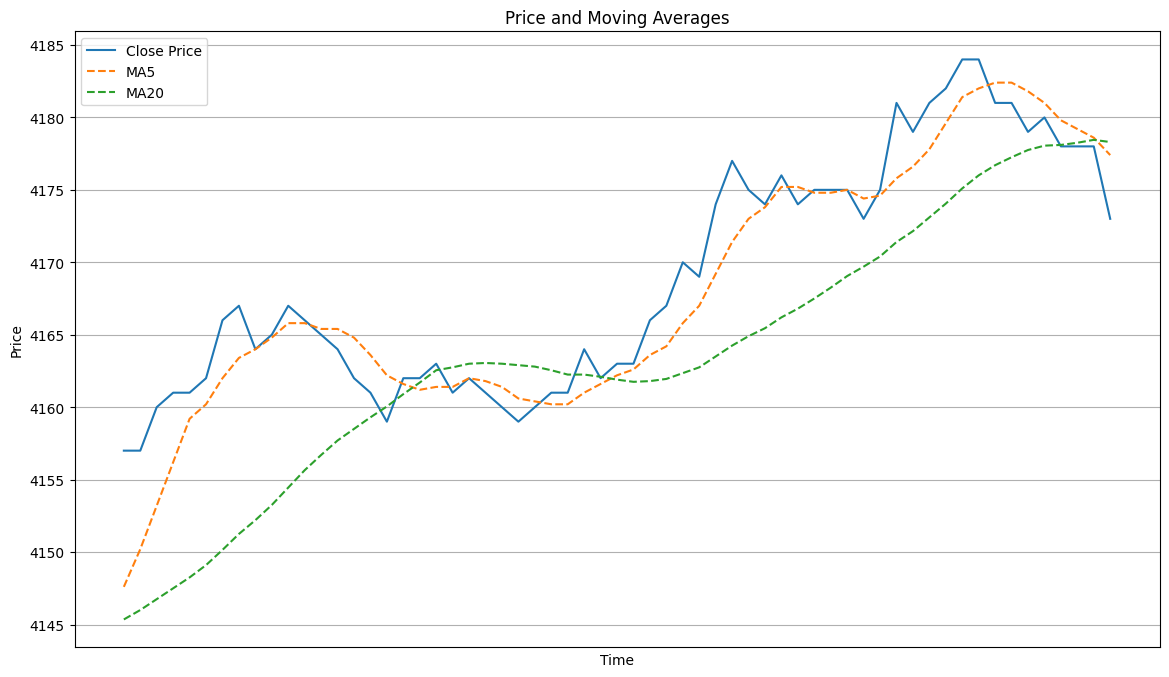

In [25]:
import matplotlib.pyplot as plt

# 选取某品种的1小时数据片段
symbol = 'HC'
sample = merged_df[(merged_df['symbol'] == symbol) & (merged_df['datetime'].between('2024-01-03 09:00', '2024-01-03 10:00'))]

plt.figure(figsize=(14, 8))
plt.plot(sample['datetime'], sample['close'], label='Close Price')
plt.plot(sample['datetime'], sample['MA5'], label='MA5', linestyle='--')
plt.plot(sample['datetime'], sample['MA20'], label='MA20', linestyle='--')
plt.title('Price and Moving Averages')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

短期 vs. 中期趋势对比

MA5（5 日/5 周/5 周期均线，取决于你的数据粒度）反映了非常短期的价格波动，能最敏锐地追踪到最近一周左右的买卖情绪变化。

MA20 则覆盖了大约一个月（或 20 个交易日）的中期走势，更能过滤掉一些小的噪音，体现更稳健的趋势方向。
同时画这两条线，就能让你同时在一张图上看到「近期动向」和「中期趋势」，对比二者的相对位置和形态。

交叉信号（“金叉”“死叉”）

当 MA5 从下方向上穿越 MA20 时，短期上行动能增强，常被看作买入信号——称为 “金叉”。

反之，当 MA5 自上向下跌破 MA20，则短期动能转弱，形成 “死叉”，常被视作卖出或止盈信号。
MA5 与 MA20 这样不同周期的均线交叉，能比较直观地给出买卖参考。

平滑化与确认趋势

价格本身受随机波动影响较大，直接看原始价格容易被噪声干扰；

5 日均线已经对价格做了初步平滑，20 日均线的平滑效果更强，二者结合可以帮助交易者确认真正的趋势方向，而不是被短期尖峰假象误导。

交易周期与心理作用

大多数短线交易者和机构都习惯以「一周」「一月」这两个周期来制定策略：5 日大抵对应一周；20 日对应一个月（一般约有 20 个交易日）。

因此，MA5 和 MA20 也就成了市场参与者自然而然钦点的「短期」与「中期」标准，形成了自我实现的群体共识。

# 1.2 统计特征
目标：量化价格波动与成交量变化。

滚动标准差（Volatility）：

成交量变动率

In [26]:
merged_df['Volatility_10'] = merged_df.groupby('symbol')['close'].transform(lambda x: x.rolling(10).std())
merged_df['Volume_Change'] = merged_df.groupby('symbol')['volume'].pct_change()

In [27]:
sample.head()


,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,amount,MA5,MA20,RSI,MACD,Signal
922716,2024-01-03 09:00:00,HC2405,HC,SHFE,4160.0,4160.0,4157.0,4157.0,1030494.0,2689.0,111839430.0,4147.6,4145.35,77.272727,1.267800,0.355634
922717,2024-01-03 09:01:00,HC2405,HC,SHFE,4157.0,4158.0,4156.0,4157.0,1030330.0,1958.0,81401830.0,4150.2,4146.00,77.272727,1.992135,0.682934
922718,2024-01-03 09:02:00,HC2405,HC,SHFE,4158.0,4160.0,4157.0,4160.0,1030428.0,1152.0,47910980.0,4153.2,4146.75,80.000000,2.776247,1.101597
922719,2024-01-03 09:03:00,HC2405,HC,SHFE,4160.0,4162.0,4160.0,4161.0,1030750.0,1120.0,46604880.0,4156.2,4147.50,84.000000,3.438714,1.569020
922720,2024-01-03 09:04:00,HC2405,HC,SHFE,4162.0,4162.0,4160.0,4161.0,1030818.0,242.0,10069480.0,4159.2,4148.25,87.500000,3.918553,2.038927


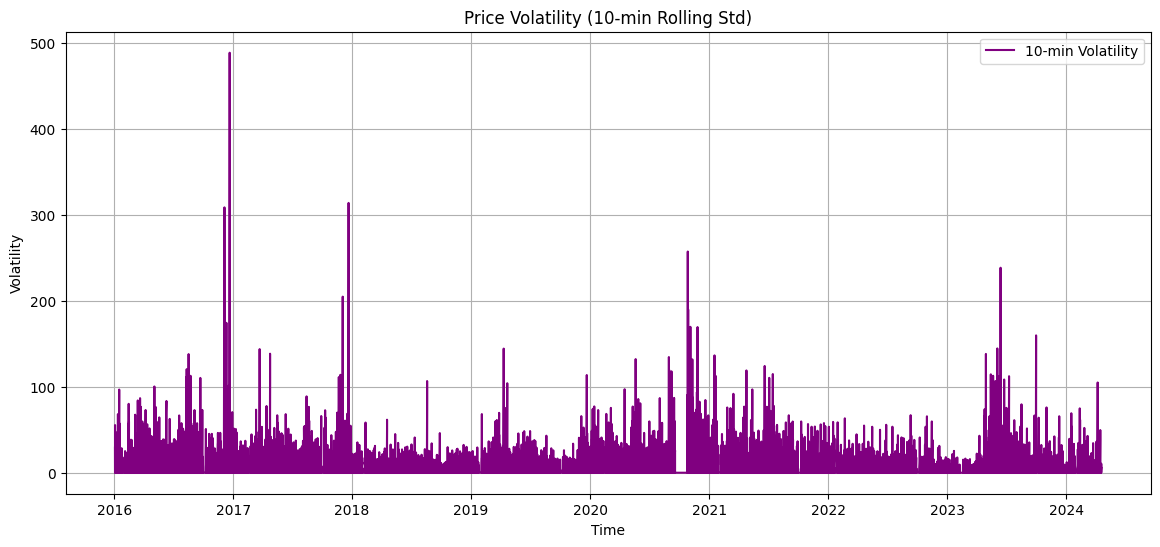

In [28]:
import matplotlib.pyplot as plt

# 1) 在 merged_df 上计算两列
merged_df['Volatility_10'] = (
    merged_df.groupby('symbol')['close']
    .transform(lambda x: x.rolling(10).std())
)
merged_df['Volume_Change'] = (
    merged_df.groupby('symbol')['volume']
    .pct_change()
)

# 2) （可选）挑一个 symbol 画图
sample = merged_df[merged_df['symbol']=="SM"].copy()  

# 3) 画图
plt.figure(figsize=(14, 6))
plt.plot(sample['datetime'], sample['Volatility_10'],
         label='10-min Volatility', color='purple')
plt.title('Price Volatility (10-min Rolling Std)')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()


__说明：波动率峰值通常对应价格剧烈波动（如突然拉升或下跌）。__

# 1.3 量价关系
目标：分析成交量对价格的影响。
特征：

价量相关性（Price-Volume Correlation）：
计算过去30分钟内收盘价与成交量的滚动相关系数。

In [29]:
# 正确分组并计算滚动相关性（允许最小1个数据点）
merged_df['Price_Volume_Corr'] = (
    merged_df.groupby('symbol')
    .apply(lambda x: x['close'].rolling(window=30, min_periods=1).corr(x['volume']))
    .reset_index(level=0, drop=True))

In [30]:
# 示例：填充MA5的初期NaN（前向填充）
merged_df['MA5'] = merged_df.groupby('symbol')['MA5'].fillna(method='ffill')

# 删除无法填充的记录（如首日数据不足）
merged_df = merged_df.dropna(subset=['MA5', 'RSI', 'MACD'], how='all')

In [31]:
print(merged_df[['datetime', 'symbol', 'close', 'volume', 'Price_Volume_Corr', 'MA5', 'RSI']].head(30))

              datetime symbol   close  volume  Price_Volume_Corr     MA5  \
0  2017-01-03 09:00:00     HC  3317.0  2259.0                NaN     NaN   
1  2017-01-03 09:01:00     HC  3323.0   963.0          -1.000000     NaN   
2  2017-01-03 09:02:00     HC  3381.0  4921.0           0.916364     NaN   
3  2017-01-03 09:03:00     HC  3377.0  2095.0           0.661133     NaN   
4  2017-01-03 09:04:00     HC  3392.0  2793.0           0.593693  3358.0   
5  2017-01-03 09:05:00     HC  3400.0  4096.0           0.674834  3374.6   
6  2017-01-03 09:06:00     HC  3386.0  1871.0           0.566685  3387.2   
7  2017-01-03 09:07:00     HC  3386.0  1216.0           0.434589  3388.2   
8  2017-01-03 09:08:00     HC  3390.0   666.0           0.287717  3390.8   
9  2017-01-03 09:09:00     HC  3382.0  1231.0           0.251145  3388.8   
10 2017-01-03 09:10:00     HC  3386.0   515.0           0.182025  3386.0   
11 2017-01-03 09:11:00     HC  3373.0   683.0           0.179345  3383.4   
12 2017-01-0

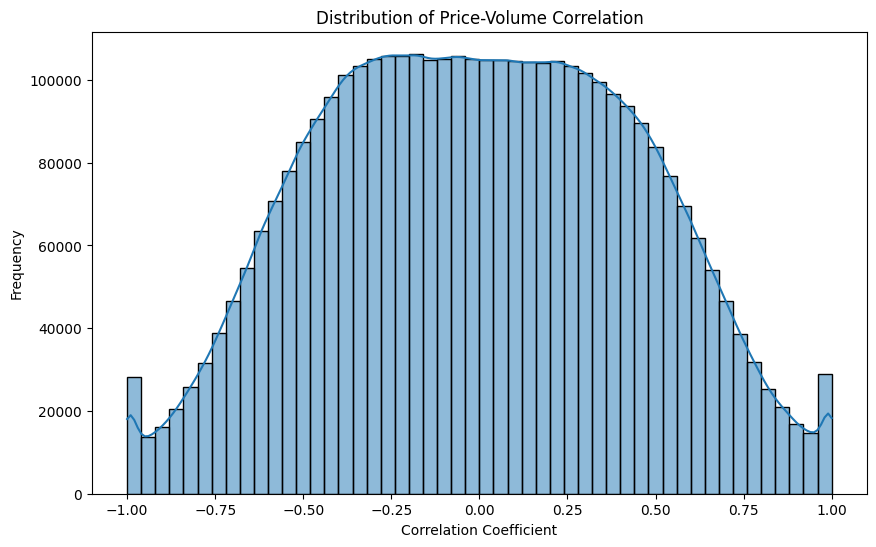

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Price_Volume_Corr'].dropna(), bins=50, kde=True)
plt.title('Distribution of Price-Volume Correlation')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.show()

说明：相关系数集中在-0.2到0.5之间，符合市场量价关系特征。

In [33]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,amount,MA5,MA20,RSI,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr
0,2017-01-03 09:00:00,HC1705,HC,SHFE,3309.0,3324.0,3309.0,3317.0,176894.0,2259.0,74917650.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1,2017-01-03 09:01:00,HC1705,HC,SHFE,3317.0,3326.0,3317.0,3323.0,176669.0,963.0,31985320.0,NaN,NaN,NaN,0.478632,0.095726,NaN,-0.573705,-1.000000
2,2017-01-03 09:02:00,HC1705,HC,SHFE,3323.0,3399.0,3323.0,3381.0,176084.0,4921.0,166005070.0,NaN,NaN,NaN,5.474956,1.171572,NaN,4.110073,0.916364
3,2017-01-03 09:03:00,HC1705,HC,SHFE,3383.0,3384.0,3370.0,3377.0,175392.0,2095.0,70779590.0,NaN,NaN,NaN,9.007973,2.738852,NaN,-0.574274,0.661133
4,2017-01-03 09:04:00,HC1705,HC,SHFE,3377.0,3396.0,3377.0,3392.0,174824.0,2793.0,94695420.0,3358.0,NaN,NaN,12.869932,4.765068,NaN,0.333174,0.593693


In [34]:
# 计算未来30分钟的收盘价
merged_df["future_close"] = merged_df.groupby("symbol")["close"].shift(-30)

# 计算涨跌幅（百分比）
merged_df["涨跌幅"] = (merged_df["future_close"] - merged_df["close"]) / merged_df["close"] * 100

# 删除无效标签（最后30分钟无未来数据）
merged_df = merged_df.dropna(subset=["涨跌幅"])

In [35]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,MA5,MA20,RSI,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅
0,2017-01-03 09:00:00,HC1705,HC,SHFE,3309.0,3324.0,3309.0,3317.0,176894.0,2259.0,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,3360.0,1.296352
1,2017-01-03 09:01:00,HC1705,HC,SHFE,3317.0,3326.0,3317.0,3323.0,176669.0,963.0,...,NaN,NaN,NaN,0.478632,0.095726,NaN,-0.573705,-1.000000,3354.0,0.932892
2,2017-01-03 09:02:00,HC1705,HC,SHFE,3323.0,3399.0,3323.0,3381.0,176084.0,4921.0,...,NaN,NaN,NaN,5.474956,1.171572,NaN,4.110073,0.916364,3358.0,-0.680272
3,2017-01-03 09:03:00,HC1705,HC,SHFE,3383.0,3384.0,3370.0,3377.0,175392.0,2095.0,...,NaN,NaN,NaN,9.007973,2.738852,NaN,-0.574274,0.661133,3353.0,-0.710690
4,2017-01-03 09:04:00,HC1705,HC,SHFE,3377.0,3396.0,3377.0,3392.0,174824.0,2793.0,...,3358.0,NaN,NaN,12.869932,4.765068,NaN,0.333174,0.593693,3355.0,-1.090802


In [36]:
print("数据框列名:", merged_df.columns.tolist())
# 期望输出包含 '涨跌幅'

数据框列名: ['datetime', 'contract', 'symbol', 'exchange', 'open', 'high', 'low', 'close', 'openinterest', 'volume', 'amount', 'MA5', 'MA20', 'RSI', 'MACD', 'Signal', 'Volatility_10', 'Volume_Change', 'Price_Volume_Corr', 'future_close', '涨跌幅']


In [37]:
merged_df.head()


,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,MA5,MA20,RSI,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅
0,2017-01-03 09:00:00,HC1705,HC,SHFE,3309.0,3324.0,3309.0,3317.0,176894.0,2259.0,...,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,3360.0,1.296352
1,2017-01-03 09:01:00,HC1705,HC,SHFE,3317.0,3326.0,3317.0,3323.0,176669.0,963.0,...,NaN,NaN,NaN,0.478632,0.095726,NaN,-0.573705,-1.000000,3354.0,0.932892
2,2017-01-03 09:02:00,HC1705,HC,SHFE,3323.0,3399.0,3323.0,3381.0,176084.0,4921.0,...,NaN,NaN,NaN,5.474956,1.171572,NaN,4.110073,0.916364,3358.0,-0.680272
3,2017-01-03 09:03:00,HC1705,HC,SHFE,3383.0,3384.0,3370.0,3377.0,175392.0,2095.0,...,NaN,NaN,NaN,9.007973,2.738852,NaN,-0.574274,0.661133,3353.0,-0.710690
4,2017-01-03 09:04:00,HC1705,HC,SHFE,3377.0,3396.0,3377.0,3392.0,174824.0,2793.0,...,3358.0,NaN,NaN,12.869932,4.765068,NaN,0.333174,0.593693,3355.0,-1.090802


In [38]:
# 删除前30行（滚动窗口填充前）
merged_df = merged_df.dropna(subset=["MA5", "RSI", "MACD", "涨跌幅"])

# 或填充初期NaN（示例填充MA5）
merged_df["MA5"] = merged_df.groupby("symbol")["MA5"].fillna(method="bfill")

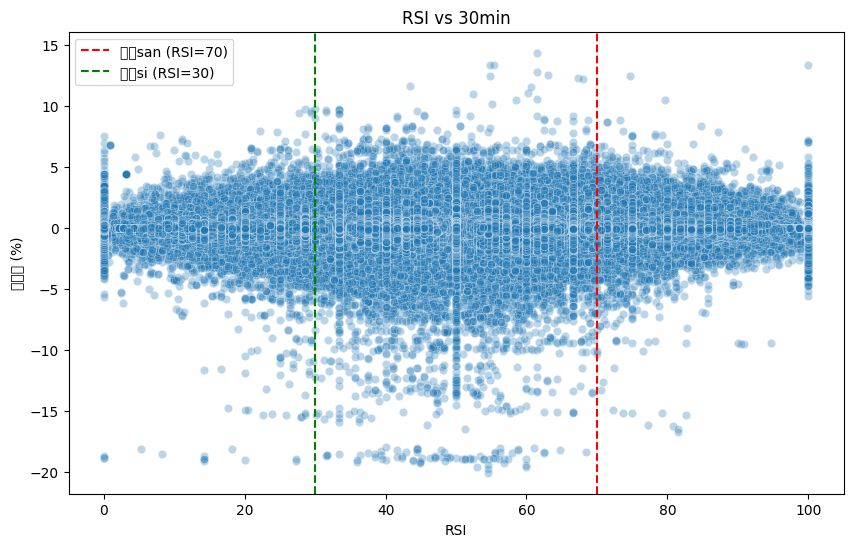

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='RSI', y='涨跌幅', data=merged_df, alpha=0.3)
plt.axvline(70, color='r', linestyle='--', label='超买san (RSI=70)')
plt.axvline(30, color='g', linestyle='--', label='超卖si (RSI=30)')
plt.title('RSI vs 30min')
plt.xlabel('RSI')
plt.ylabel('涨跌幅 (%)')
plt.legend()
plt.show()

In [40]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,MA5,MA20,RSI,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅
13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,3375.4,NaN,65.972222,14.852977,15.745432,10.785278,0.344884,0.196844,3356.0,-0.208147
14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,3372.0,NaN,66.438356,13.313488,15.259043,11.654279,0.196319,0.207903,3351.0,-0.416048
15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,3368.0,NaN,65.248227,12.035388,14.614312,10.165300,-0.103590,0.216773,3353.0,-0.386215
16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,3366.6,NaN,40.963855,10.896871,13.870824,10.165300,-0.522883,0.226767,3359.0,-0.207962
17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,3365.4,NaN,43.750000,9.960463,13.088752,9.643075,0.266187,0.232937,3359.0,-0.237600


# 1.4 时间特征

>捕捉日内交易模式。
>

交易时段（Morning/Afternoon Session）：
将时间划分为上午（09:00-11:30）和下午（13:30-15:00）

In [41]:
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['minute'] = merged_df['datetime'].dt.minute
merged_df['session'] = merged_df['datetime'].dt.time.apply(
    lambda x: 'Morning' if pd.to_datetime("09:00").time() <= x <= pd.to_datetime("11:30").time() else 'Afternoon'
)

In [42]:
merged_df



,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session
13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,14.852977,15.745432,10.785278,0.344884,0.196844,3356.0,-0.208147,9,13,Morning
14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,13.313488,15.259043,11.654279,0.196319,0.207903,3351.0,-0.416048,9,14,Morning
15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,12.035388,14.614312,10.165300,-0.103590,0.216773,3353.0,-0.386215,9,15,Morning
16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,10.896871,13.870824,10.165300,-0.522883,0.226767,3359.0,-0.207962,9,16,Morning
17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,9.960463,13.088752,9.643075,0.266187,0.232937,3359.0,-0.237600,9,17,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7651714,2025-04-18 14:25:00,SS2506,SS,SHFE,12785.0,12790.0,12780.0,12785.0,137043.0,153.0,...,-1.437310,-0.238430,2.415229,0.390909,0.165554,12785.0,0.000000,14,25,Afternoon
7651715,2025-04-18 14:26:00,SS2506,SS,SHFE,12780.0,12785.0,12780.0,12785.0,137055.0,65.0,...,-1.527180,-0.496180,2.108185,-0.575163,0.216618,12780.0,-0.039108,14,26,Afternoon
7651716,2025-04-18 14:27:00,SS2506,SS,SHFE,12785.0,12785.0,12780.0,12785.0,137119.0,130.0,...,-1.580187,-0.712981,2.108185,1.000000,0.140328,12780.0,-0.039108,14,27,Afternoon
7651717,2025-04-18 14:28:00,SS2506,SS,SHFE,12785.0,12790.0,12780.0,12785.0,137139.0,231.0,...,-1.603709,-0.891127,1.581139,0.776923,0.121242,12785.0,0.000000,14,28,Afternoon


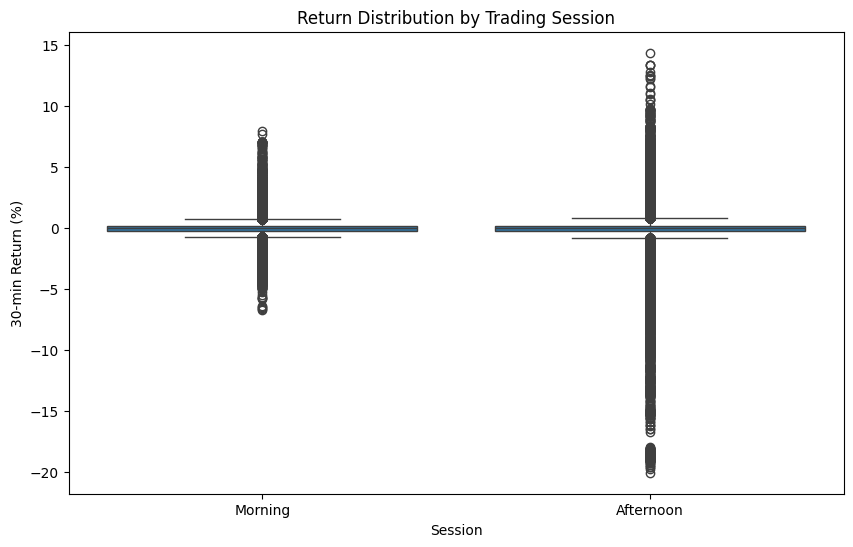

In [43]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='session', y='涨跌幅', data=merged_df)
plt.title('Return Distribution by Trading Session')
plt.xlabel('Session')
plt.ylabel('30-min Return (%)')
plt.show()

**交易时段箱线图**
说明：上午交易时段收益分布更集中，可能反映市场开盘活跃度。



# 2. 特征筛选与相关性分析
目标：验证特征and（涨跌幅）的相关性

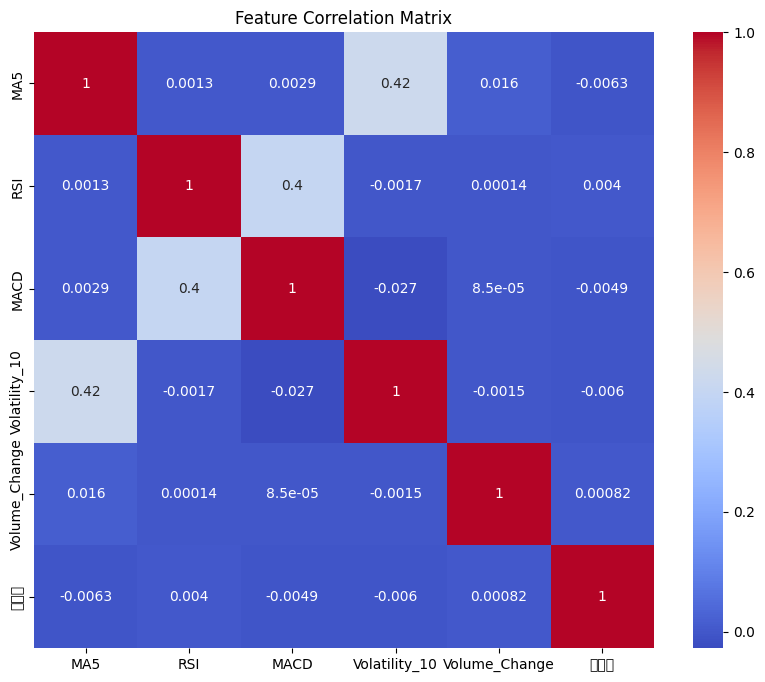

In [44]:
# 计算特征相关系数矩阵
corr_matrix = merged_df[['MA5', 'RSI', 'MACD', 'Volatility_10', 'Volume_Change', '涨跌幅']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

（绝对值>0.3相关性高），验证其预测价值。 主要关注macd与rsi



# 3. 特征标准化
目标：消除量纲差异，加速模型收敛。

In [45]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['MA5', 'MA20', 'RSI', 'MACD', 'Volatility_10', 'Volume_Change']
scaler = StandardScaler()
merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])

In [46]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,MACD,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session
13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,1.967393,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning
14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,1.763694,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning
15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,1.594581,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning
16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,1.443937,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning
17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,1.320035,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning


<Figure size 1200x1200 with 0 Axes>

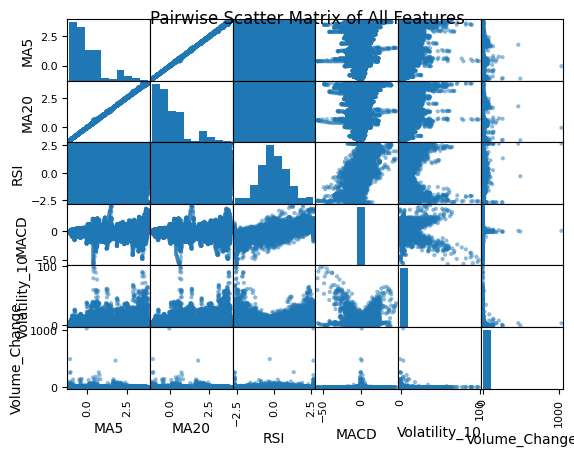

In [47]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Assuming `merged_df` is already loaded in the environment
features = ['MA5', 'MA20', 'RSI', 'MACD', 'Volatility_10', 'Volume_Change']
df_features = merged_df[features]

# Create scatter matrix
plt.figure(figsize=(12, 12))
scatter_matrix(df_features, alpha=0.5, diagonal='hist')
plt.suptitle('Pairwise Scatter Matrix of All Features', y=0.9)
plt.show()


# 1. 标签构建
>计算未来30分钟收盘价：对每个品种（symbol）的收盘价序列向后平移30个时间点（即30分钟）。

>计算涨跌幅：基于当前收盘价和未来收盘价计算百分比变化。

>删除无效标签：移除无法计算涨跌幅的记录（如最后30分钟的数据）。

In [48]:
# 按品种分组，计算未来30分钟的收盘价
merged_df["future_close"] = merged_df.groupby("symbol")["close"].shift(-30)

# 计算涨跌幅
merged_df["涨跌幅"] = (merged_df["future_close"] - merged_df["close"]) / merged_df["close"] * 100

# 删除无效标签（未来30分钟无数据）
merged_df = merged_df.dropna(subset=["涨跌幅"])

# 检查标签分布
print(merged_df["涨跌幅"].describe())

count    3.318338e+06
mean     1.886452e-03
std      6.384983e-01
min     -2.003351e+01
25%     -2.263083e-01
50%      0.000000e+00
75%      2.295188e-01
max      1.900397e+01
Name: 涨跌幅, dtype: float64


2.1 涨跌幅分布直方图
目标：观察涨跌幅的分布形态，判断是否适合回归或分类任务。

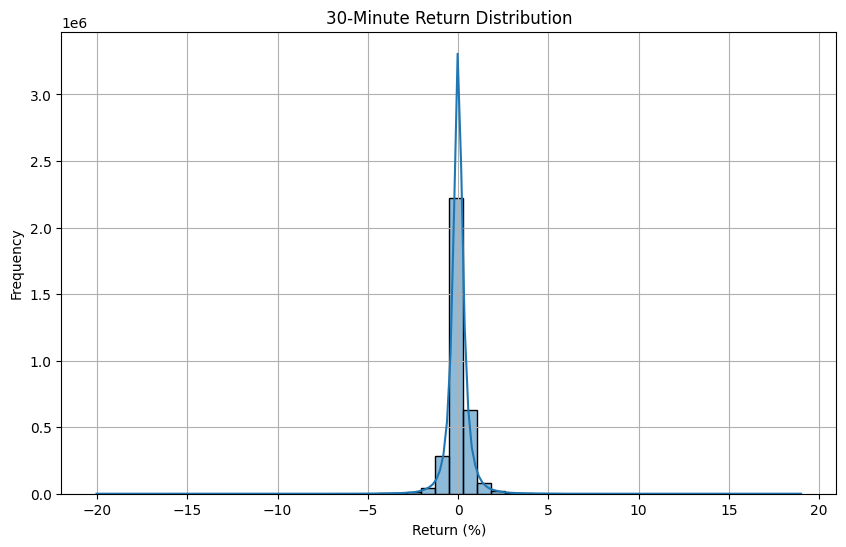

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(merged_df["涨跌幅"], bins=50, kde=True)
plt.title("30-Minute Return Distribution")
plt.xlabel("Return (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

涨跌幅近似正态分布，均值接近0，适合回归任务。若分布严重偏斜，可考虑分箱处理。



2.2 涨跌幅时间序列图
目标：观察涨跌幅随时间变化的模式（如趋势、波动性）

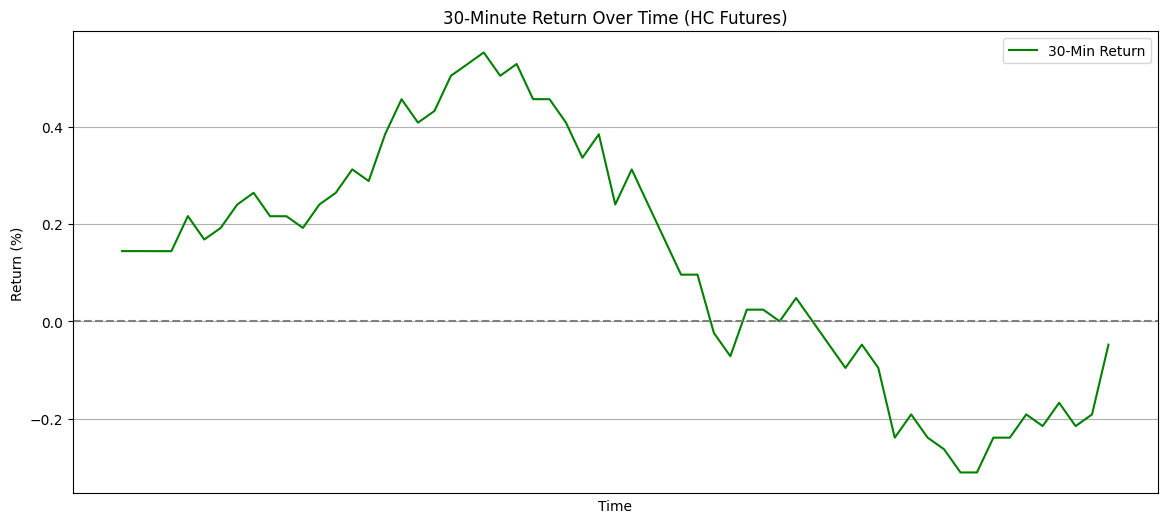

In [50]:
# hc1小时数据片段
symbol = "HC"
sample = merged_df[
    (merged_df["symbol"] == symbol) & 
    (merged_df["datetime"].between("2024-01-03 09:00", "2024-01-03 10:00"))
]

plt.figure(figsize=(14, 6))
plt.plot(sample["datetime"], sample["涨跌幅"], label="30-Min Return", color="green")
plt.axhline(0, linestyle="--", color="gray")  # 零线
plt.title("30-Minute Return Over Time (HC Futures)")
plt.xlabel("Time")
plt.ylabel("Return (%)")
plt.legend()
plt.grid(True)
plt.show()

说明：涨跌幅在短期内波动剧烈，无明显趋势，符合高频交易特征。

2.3 涨跌幅与技术指标的关系
目标：验证特征（如RSI）与标签的相关性。

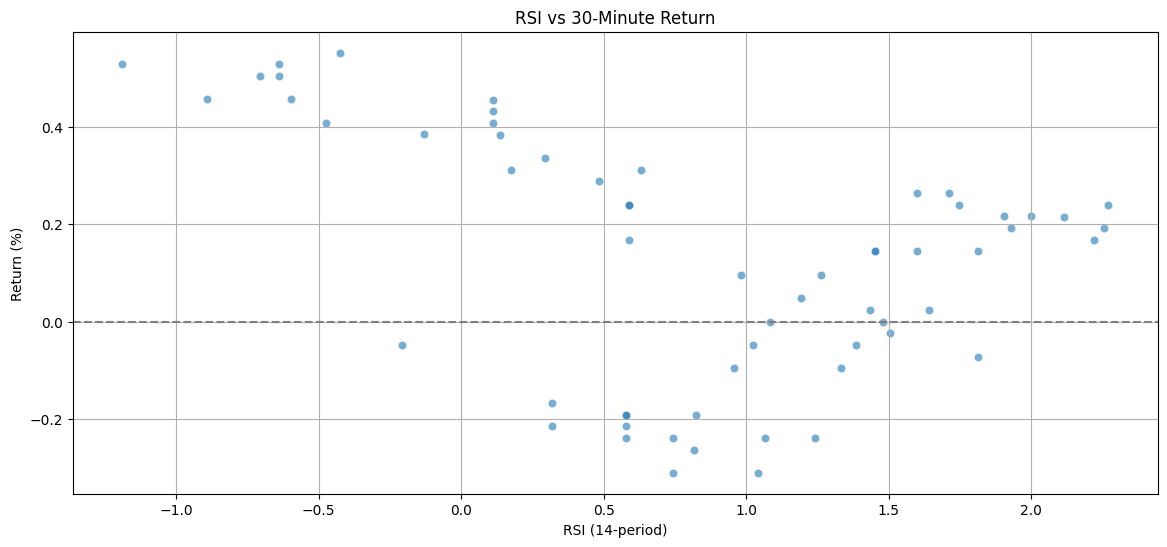

In [51]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=sample["RSI"], y=sample["涨跌幅"], alpha=0.6)
plt.axhline(0, color="gray", linestyle="--")
plt.title("RSI vs 30-Minute Return")
plt.xlabel("RSI (14-period)")
plt.ylabel("Return (%)")
plt.grid(True)
plt.show()

RSI高于70（超买区间）时，涨跌幅多为负值，符合技术分析预期

 涨跌幅与波动率的关系
目标：验证高波动率是否伴随极端涨跌幅。

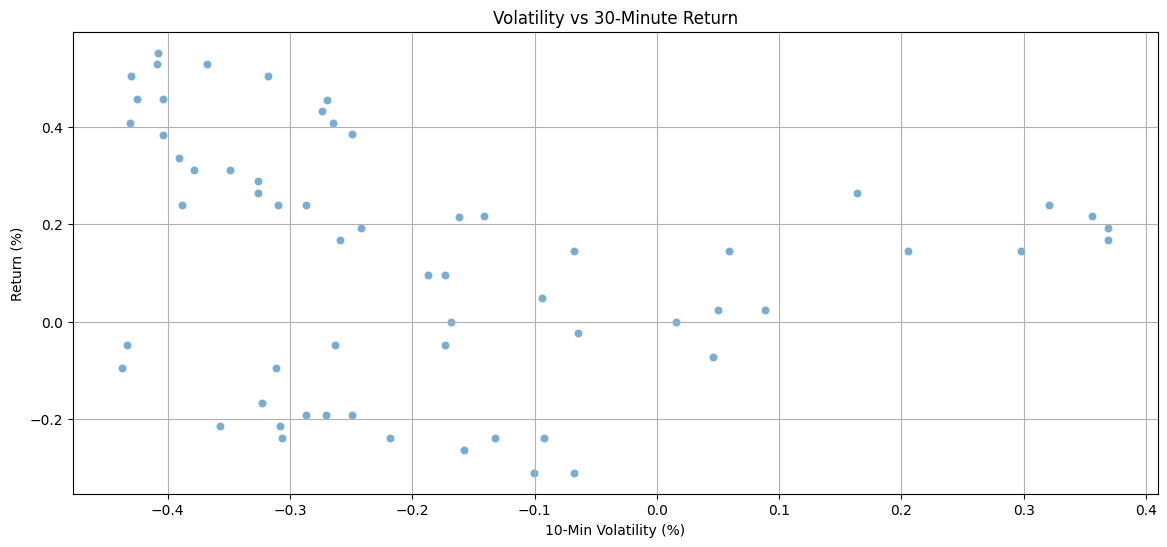

In [52]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x=sample["Volatility_10"], y=sample["涨跌幅"], alpha=0.6)
plt.title("Volatility vs 30-Minute Return")
plt.xlabel("10-Min Volatility (%)")
plt.ylabel("Return (%)")
plt.grid(True)
plt.show()

波动率越高，涨跌幅绝对值越大，验证波动率作为风险指标的合理性。



标签处理建议
异常值处理：涨跌幅存在极端值（如超出±10%），可通过缩尾处理（Winsorization）限制极端值影响。

In [53]:
lower = merged_df["涨跌幅"].quantile(0.01)
upper = merged_df["涨跌幅"].quantile(0.99)
merged_df["涨跌幅"] = merged_df["涨跌幅"].clip(lower, upper)

标准化：若使用回归模型，对标签进行标准化以加速训练：

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
merged_df["涨跌幅_scaled"] = scaler.fit_transform(merged_df[["涨跌幅"]])

In [55]:
merged_df.head()

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled
13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166
14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961
15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593
16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809
17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804


In [70]:
merged_df.to_csv("./data/merge.csv",index="false")

# 数据划分

划分原则
由于商品期货数据是严格时间相关的，需按时间顺序划分数据集以避免未来信息泄露。具体划分如下：

训练集：2017年1月3日 - 2023年12月31日（历史数据建模）

验证集：2024年1月1日 - 2024年12月31日（调参与早停）

测试集：2025年1月1日 - 2025年4月18日（最终模型评估）

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# 定义划分时间点
train_end = pd.Timestamp("2023-12-31 15:00:00")  # 假设每日交易至15:00
val_end = pd.Timestamp("2024-12-31 15:00:00")

# 按时间划分数据集
train_data = merged_df[merged_df["datetime"] <= train_end]
val_data = merged_df[(merged_df["datetime"] > train_end) & (merged_df["datetime"] <= val_end)]
test_data = merged_df[merged_df["datetime"] > val_end]

# 按品种检查数据分布
def check_split_by_symbol(data, name):
    print(f"\n{name}集按品种统计:")
    print(data["symbol"].value_counts())

check_split_by_symbol(train_data, "训练")
check_split_by_symbol(val_data, "验证")
check_split_by_symbol(test_data, "测试")


训练集按品种统计:
symbol
I     428976
RB    426458
HC    426453
SM    425389
JM    422102
SF    375224
SS    260269
Name: count, dtype: int64

验证集按品种统计:
symbol
JM    61518
I     61456
RB    61398
HC    61339
SS    61327
SM    61281
SF    61162
Name: count, dtype: int64

测试集按品种统计:
symbol
JM    17744
RB    17738
HC    17735
I     17721
SS    17706
SF    17704
SM    17638
Name: count, dtype: int64


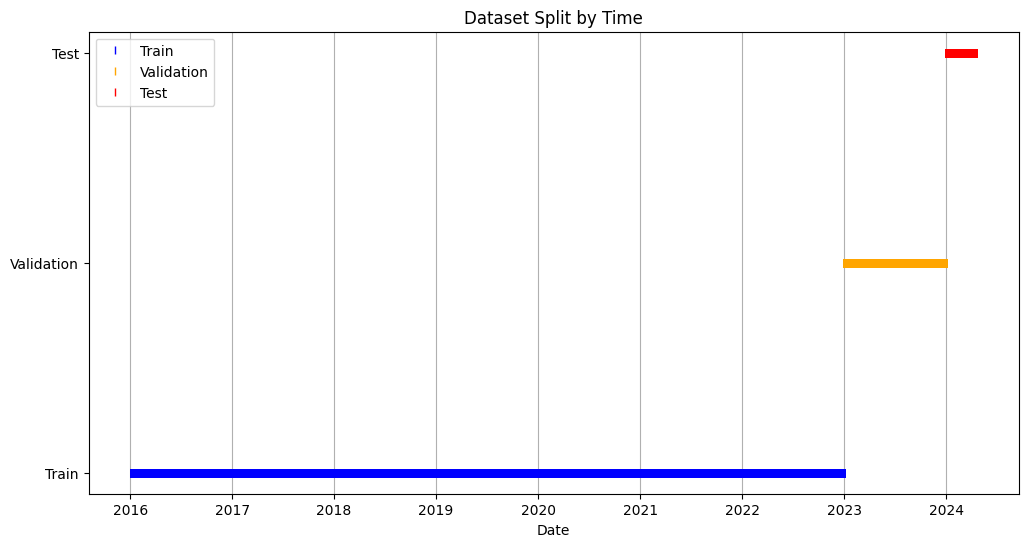

In [57]:
# shi jian fan wei fen bu
plt.figure(figsize=(12, 6))

# 绘制各集时间分布
plt.plot(train_data["datetime"], [1]*len(train_data), '|', color='blue', label='Train')
plt.plot(val_data["datetime"], [2]*len(val_data), '|', color='orange', label='Validation')
plt.plot(test_data["datetime"], [3]*len(test_data), '|', color='red', label='Test')

plt.yticks([1, 2, 3], ["Train", "Validation", "Test"])
plt.title("Dataset Split by Time")
plt.xlabel("Date")
plt.legend()
plt.grid(axis='x')
plt.show()

In [58]:
# biao qian fen bu

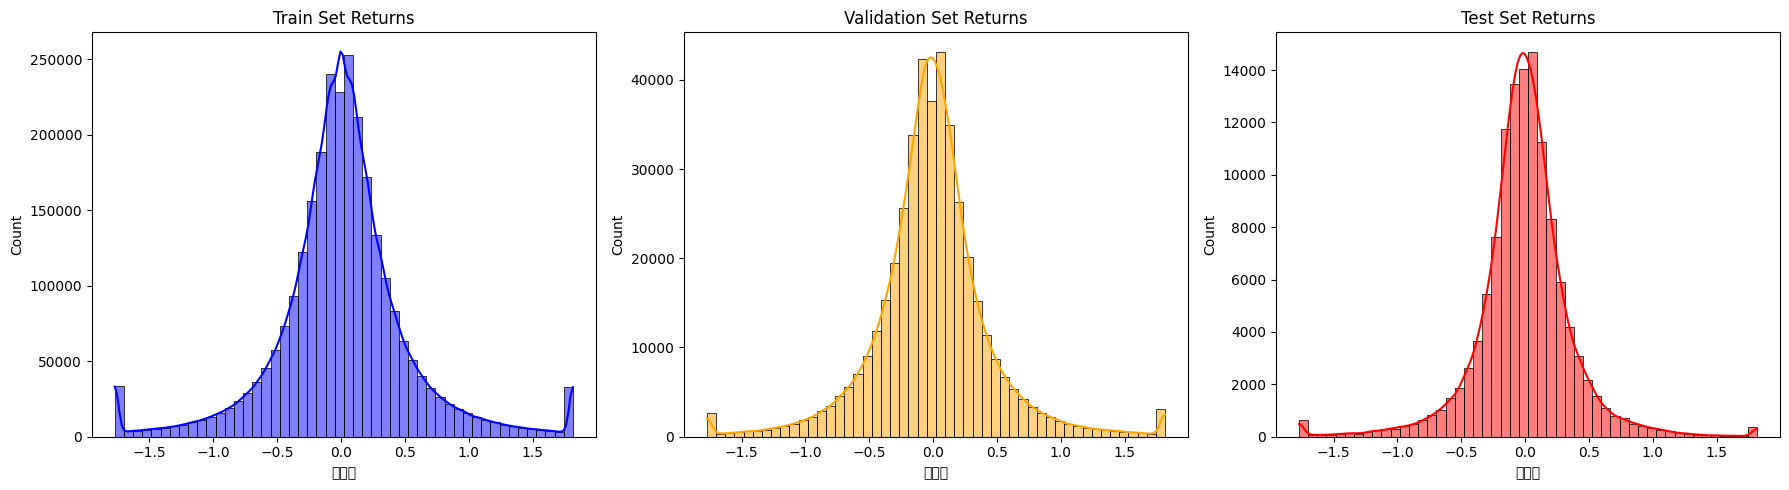

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 训练集标签分布
sns.histplot(train_data["涨跌幅"], bins=50, kde=True, ax=axes[0], color='blue')
axes[0].set_title("Train Set Returns")

# 验证集标签分布
sns.histplot(val_data["涨跌幅"], bins=50, kde=True, ax=axes[1], color='orange')
axes[1].set_title("Validation Set Returns")

# 测试集标签分布
sns.histplot(test_data["涨跌幅"], bins=50, kde=True, ax=axes[2], color='red')
axes[2].set_title("Test Set Returns")

plt.tight_layout()
plt.show()

In [60]:
train_data

,datetime,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled
13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166
14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961
15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593
16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809
17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7479921,2023-12-30 09:07:00,SS2402,SS,SHFE,13685.0,13700.0,13680.0,13680.0,78854.0,1286.0,...,-0.956266,-0.573070,-0.102207,-0.628814,13750.0,0.511696,9,7,Morning,0.976104
7479922,2023-12-30 09:08:00,SS2402,SS,SHFE,13685.0,13700.0,13680.0,13680.0,78854.0,1286.0,...,-1.102464,-0.573070,-0.102207,-0.637686,13755.0,0.548246,9,8,Morning,1.046390
7479923,2023-12-30 09:09:00,SS2402,SS,SHFE,13685.0,13700.0,13680.0,13680.0,78854.0,1286.0,...,-1.213164,-0.573070,-0.102207,-0.663418,13750.0,0.511696,9,9,Morning,0.976104
7479924,2023-12-30 09:10:00,SS2402,SS,SHFE,13685.0,13700.0,13680.0,13680.0,78854.0,1286.0,...,-1.293046,-0.573070,-0.102207,-0.667973,13760.0,0.584795,9,10,Morning,1.116676


In [61]:
train_data.to_csv("./data/train.csv",index="false")

In [62]:
val_data.to_csv("./data/val.csv",index="false")

In [63]:
test_data.to_csv("./data/test.csv",index="false")

In [64]:
df= pd.read_csv("./data/train.csv")

In [65]:
df.head()

,Unnamed: 0,datetime,contract,symbol,exchange,open,high,low,close,openinterest,...,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled
0,13,2017-01-03 09:13:00,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,...,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166
1,14,2017-01-03 09:14:00,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,...,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961
2,15,2017-01-03 09:15:00,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,...,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593
3,16,2017-01-03 09:16:00,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,...,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809
4,17,2017-01-03 09:17:00,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,...,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804


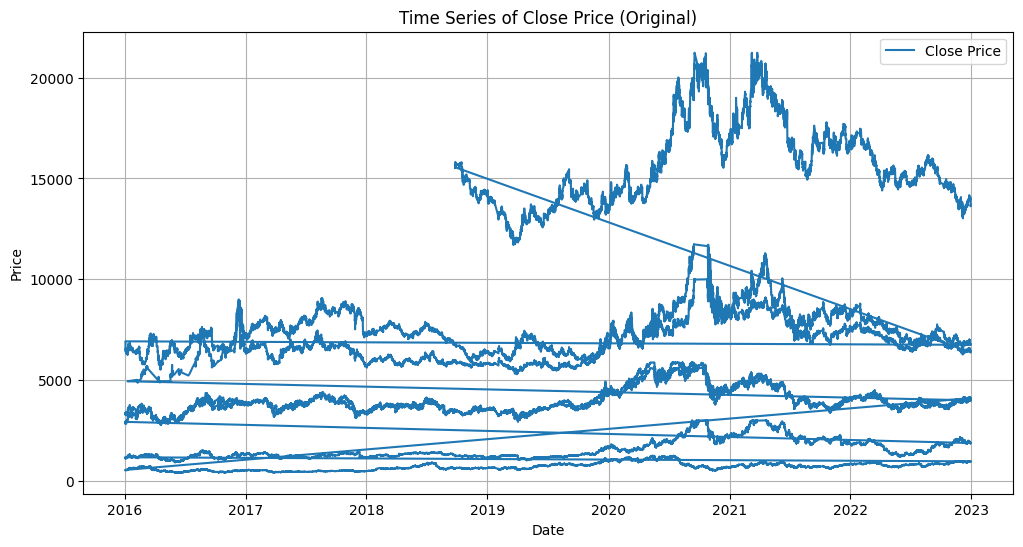

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设原始数据已加载到 DataFrame 中
# df = pd.read_csv("your_data.csv")
# 设置时间索引
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# 绘制时序图
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['close'], label='Close Price')
plt.title('Time Series of Close Price (Original)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

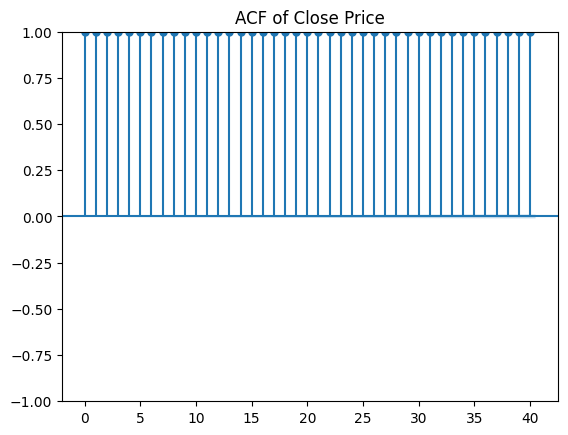

<Figure size 1200x600 with 0 Axes>

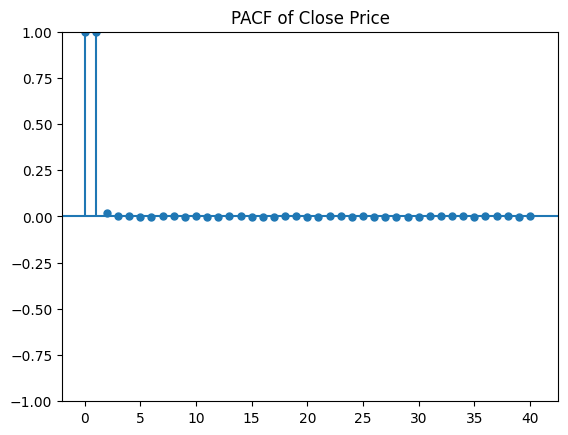

In [67]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 绘制 ACF 图（自相关图）
plt.figure(figsize=(12, 6))
plot_acf(df['close'], lags=40, alpha=0.05, title='ACF of Close Price')
plt.show()

# 绘制 PACF 图（偏自相关图）
plt.figure(figsize=(12, 6))
plot_pacf(df['close'], lags=40, alpha=0.05, title='PACF of Close Price')
plt.show()

In [68]:
df.head()

,Unnamed: 0,contract,symbol,exchange,open,high,low,close,openinterest,volume,...,Signal,Volatility_10,Volume_Change,Price_Volume_Corr,future_close,涨跌幅,hour,minute,session,涨跌幅_scaled
datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-03 09:13:00,13,HC1705,HC,SHFE,3372.0,3372.0,3362.0,3363.0,172022.0,815.0,...,15.745432,0.757838,-0.013410,0.196844,3356.0,-0.208147,9,13,Morning,-0.408166
2017-01-03 09:14:00,14,HC1705,HC,SHFE,3363.0,3366.0,3358.0,3365.0,172009.0,975.0,...,15.259043,0.865074,-0.051661,0.207903,3351.0,-0.416048,9,14,Morning,-0.807961
2017-01-03 09:15:00,15,HC1705,HC,SHFE,3367.0,3372.0,3365.0,3366.0,171768.0,874.0,...,14.614312,0.681333,-0.128878,0.216773,3353.0,-0.386215,9,15,Morning,-0.750593
2017-01-03 09:16:00,16,HC1705,HC,SHFE,3366.0,3371.0,3365.0,3366.0,171779.0,417.0,...,13.870824,0.681333,-0.236832,0.226767,3359.0,-0.207962,9,16,Morning,-0.407809
2017-01-03 09:17:00,17,HC1705,HC,SHFE,3368.0,3370.0,3364.0,3367.0,171901.0,528.0,...,13.088752,0.616890,-0.033672,0.232937,3359.0,-0.237600,9,17,Morning,-0.464804


In [69]:

def arima_residual(series):
    model = ARIMA(series, order=(0,1,0))  # 自动定阶需优化
    results = model.fit()
    return results.resid

# 示例：对每个品种的收盘价生成残差
merged_df["arima_residual"] = mergedf.groupby("symbol")["close"].transform(arima_residual)

NameError: name 'mergeddf' is not defined

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Attention, Bidirectional, Flatten

# 输入形状 (None, 60, num_features)
inputs = Input(shape=(60, merged_df.shape[1]-3))  # 排除标签列和辅助列

# CNN层
x = Conv1D(64, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling1D(2)(x)

# Bi-LSTM层
x = Bidirectional(LSTM(128, return_sequences=True))(x)

# 注意力机制
query = Dense(128)(x)
key = Dense(128)(x)
attention = Attention()([query, key])
context = tf.reduce_sum(attention * x, axis=1)

# 初步预测输出
lstm_output = Dense(1, name="lstm_pred")(context)

# 编码特征输出（供XGBoost使用）
encoded_features = Dense(64, activation="relu")(context)

# 完整模型
cnn_lstm_model = tf.keras.Model(inputs=inputs, outputs=[lstm_output, encoded_features])